In [1]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

In [2]:
# Model
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(3, 3)
    self.hidden1 = torch.nn.Linear(3, 3)
    self.output  = torch.nn.Linear(3, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = torch.selu(self.hidden1(z))
    z = torch.relu(self.output(z))
    return z

In [3]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y = model(testset.x_data)
    
    # R^2
    SSR = torch.sum(torch.square(pred_Y - testset.y_data))
    SST = torch.sum(torch.square(pred_Y - torch.mean(testset.y_data)))
    r2 = 1 - SSR/SST

    # RMSE
    rmse = torch.sqrt(torch.mean(torch.square(pred_Y - testset.y_data)))
    return r2, rmse

In [4]:
# Create network
device = torch.device("cpu")
net = Net().to(device)

In [6]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]

    tmp_x = np.concatenate((Tz_k, Tsa_k1, msa_k1), axis=1)
    tmp_y = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]

    self.x_data = torch.tensor(tmp_x, dtype=torch.float32)
    self.y_data = torch.tensor(tmp_y, dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp  = self.x_data[idx]
    outp = self.y_data[idx]
    sample = {'inp':inp, 'outp':outp}
    return sample

# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train = 128
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

In [7]:
train_ds.x_data.shape

torch.Size([128, 3])

In [30]:
# train model
max_epochs = 20000
loss_func  = torch.nn.MSELoss()
optimizer  = torch.optim.Adam(net.parameters(), lr=0.001)

R2_train   = np.array([])
RMSE_train = np.array([])
R2_test    = np.array([])
RMSE_test  = np.array([])

train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
for epoch in range(0, max_epochs+1):
    net.train()
    loss  = 0
    count = 0
    for (_, batch) in enumerate(train_ldr):
        X = batch['inp']
        Y = batch['outp']

        optimizer.zero_grad()
        output = net(X)                    # compute the output of the Network
        loss_val = loss_func(output, Y)    # loss function
        loss += loss_val.item()            # accumulate
        loss_val.backward()                # gradients
        optimizer.step()                   # update paramters
        count += 1

    net.eval()
    R2_train   = np.append(R2_train, eval(net, train_ds)[0].item())
    RMSE_train = np.append(RMSE_train, eval(net, train_ds)[1].item())
    R2_test    = np.append(R2_test, eval(net, test_ds)[0].item())
    RMSE_test  = np.append(RMSE_test, eval(net, test_ds)[1].item())


    if(epoch%1000==0):
        print("epoch = %5d \t loss = %8.3f \t RMSE = %6.3f \t R2 = %7.5f" % (epoch, loss/count, eval(net, test_ds)[1].item(), eval(net, test_ds)[0].item()))

epoch =     0 	 loss = 3618.429 	 RMSE = 62.252 	 R2 = 0.00169
epoch =  1000 	 loss =  217.505 	 RMSE = 21.141 	 R2 = 0.08645
epoch =  2000 	 loss =  131.193 	 RMSE = 16.389 	 R2 = 0.11200
epoch =  3000 	 loss =    3.336 	 RMSE =  2.502 	 R2 = 0.51258
epoch =  4000 	 loss =    1.332 	 RMSE =  1.332 	 R2 = 0.68699
epoch =  5000 	 loss =    0.387 	 RMSE =  0.720 	 R2 = 0.87167
epoch =  6000 	 loss =    0.011 	 RMSE =  0.160 	 R2 = 0.99213
epoch =  7000 	 loss =    0.007 	 RMSE =  0.140 	 R2 = 0.99391
epoch =  8000 	 loss =    0.007 	 RMSE =  0.139 	 R2 = 0.99397
epoch =  9000 	 loss =    0.007 	 RMSE =  0.139 	 R2 = 0.99400
epoch = 10000 	 loss =    0.007 	 RMSE =  0.138 	 R2 = 0.99406
epoch = 11000 	 loss =    0.007 	 RMSE =  0.136 	 R2 = 0.99427
epoch = 12000 	 loss =    0.008 	 RMSE =  0.121 	 R2 = 0.99544
epoch = 13000 	 loss =    0.008 	 RMSE =  0.152 	 R2 = 0.99281
epoch = 14000 	 loss =    0.007 	 RMSE =  0.139 	 R2 = 0.99394
epoch = 15000 	 loss =    0.007 	 RMSE =  0.124 	 R2 = 

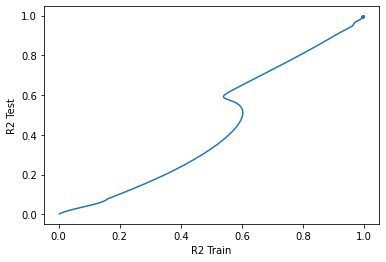

In [31]:
plt.plot(R2_train, R2_test)
plt.xlabel('R2 Train')
plt.ylabel('R2 Test')
plt.show()

In [32]:
def plot(dataset, size):
  with torch.no_grad():
      pred_Y = net(dataset.x_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

RMSE: 0.07803328335285187
R2:   0.9979503154754639


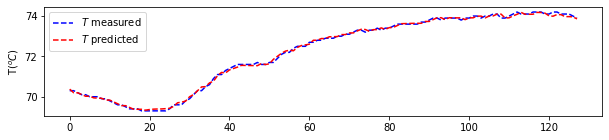

In [33]:
net.eval()
print("RMSE:", eval(net, train_ds)[1].item())
print("R2:  ", eval(net, train_ds)[0].item())
plot(train_ds, (10, 2))

RMSE: 0.12282294034957886
R2:   0.9953398108482361


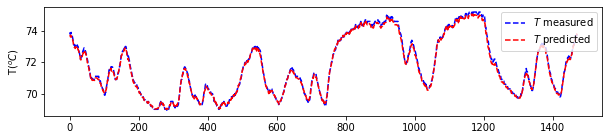

In [34]:
net.eval()
print("RMSE:", eval(net, test_ds)[1].item())
print("R2:  ", eval(net, test_ds)[0].item())
plot(test_ds, (10, 2))

In [35]:
print(np.argmax(R2_test))
print(np.max(R2_test))

19953
0.9969319701194763


In [36]:
# PATH = 'C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz.pt'
# torch.save(net, PATH)